In [1]:
import pickle
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict

from data_loader import DataLoader

In [2]:
dataloader = DataLoader(
	data_cols=["avg_amplitude","max_amplitude","mean_percycle_max_speed","mean_percycle_avg_speed","mean_tapping_interval","amp_slope","speed_slope","cov_tapping_interval","cov_amp","cov_per_cycle_speed_maxima","cov_per_cycle_speed_avg","num_interruptions2"],
	label_cols=["ids", "UPDRS", "visit", "on_medication", "hand"]
)

y_train = np.array(dataloader.get_train_labels()[:, 1], dtype=np.int64)
y_test = np.array(dataloader.get_test_labels()[:, 1], dtype=np.int64)
y_holdout = np.array(dataloader.get_holdout_labels()[:, 1], dtype=np.int64)

Loading data
110 train patients
54 test patients
24 holdout patients
Data loaded
---------------------------------------


In [3]:
classifier_result_names = [
	"direct",
	"TL_FFN_REG_UPDRS_0.01L2_0.1D_1e-05LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist", # Epoch 7
	"TL_FFN_REG_UPDRS_0.01L2_0.5D_1e-05LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist", # Epoch 7
	"TL_FFN_REG_UPDRS_0.01L2_0.5D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist", # Epoch 66
	"TL_FFN_REG_SMALL_UPDRS_0.01L2_0.1D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist", # Epoch 29
	"TL_FFN_REG_SMALL_UPDRS_0.01L2_0.5D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist", # Epoch 34
	"TL_FFN_REG_V2_UPDRS_0.01L2_0.1D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist", # Epoch 22
	"TL_FFN_REG_V2_UPDRS_0.01L2_0.3D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist", # Epoch 14
	"TL_FFN_REG_V2_UPDRS_0.01L2_0.5D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist", # Epoch 30
	"TL_FFN_REG_V2_12DIM_UPDRS_0.01L2_0.1D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist", # Epoch 33 
]

In [4]:
accuracies: Dict[str, pd.DataFrame] = {}
confusion_matrices: Dict[str, pd.DataFrame] = {}
balanced_accuracies: Dict[str, pd.DataFrame] = {}
f1_scores: Dict[str, pd.DataFrame] = {}
precisions: Dict[str, pd.DataFrame] = {}
acceptable_accuracies: Dict[str, pd.DataFrame] = {}
y_true_dists: Dict[str, pd.DataFrame] = {}
for classifier_result in classifier_result_names:
	with open(f"classifier_results/{classifier_result}.pkl", "rb") as file:
		results = pickle.load(file)
	
	classifiers = np.array(list(results["train"].keys()))

	# Gets all the predicted classes for each classifier
	y_train_pred = np.array(list(results["train"].values())).argmax(axis=-1)
	y_test_pred = np.array(list(results["test"].values())).argmax(axis=-1)
	y_holdout_pred = np.array(list(results["holdout"].values())).argmax(axis=-1)

	accuracies[classifier_result] = pd.DataFrame(
		{
			"train_acc": sklearn.metrics.accuracy_score(y_train, y_train_pred_single),
			"test_acc": sklearn.metrics.accuracy_score(y_test, y_test_pred_single),
			"holdout_acc": sklearn.metrics.accuracy_score(y_holdout, y_holdout_pred_single),
		} for (name, y_train_pred_single, y_test_pred_single, y_holdout_pred_single) in zip(classifiers, y_train_pred, y_test_pred, y_holdout_pred)  
	)

	confusion_matrices[classifier_result] = pd.DataFrame(
		{
			"train_matrix": sklearn.metrics.confusion_matrix(y_train, y_train_pred_single),
			"test_matrix": sklearn.metrics.confusion_matrix(y_test, y_test_pred_single),
			"holdout_matrix": sklearn.metrics.confusion_matrix(y_holdout, y_holdout_pred_single),
		} for (name, y_train_pred_single, y_test_pred_single, y_holdout_pred_single) in zip(classifiers, y_train_pred, y_test_pred, y_holdout_pred)   
	)
 
	balanced_accuracies[classifier_result] = pd.DataFrame(
		{
			"train_bal_acc": sklearn.metrics.balanced_accuracy_score(y_train, y_train_pred_single),
			"test_bal_acc": sklearn.metrics.balanced_accuracy_score(y_test, y_test_pred_single),
			"holdout_bal_acc": sklearn.metrics.balanced_accuracy_score(y_holdout, y_holdout_pred_single),
		} for (name, y_train_pred_single, y_test_pred_single, y_holdout_pred_single) in zip(classifiers, y_train_pred, y_test_pred, y_holdout_pred)  
	)
 
	f1_scores[classifier_result] = pd.DataFrame(
		{
			"train_f1": sklearn.metrics.f1_score(y_train, y_train_pred_single, average='macro', zero_division=0),
			"test_f1": sklearn.metrics.f1_score(y_test, y_test_pred_single, average='macro', zero_division=0),
			"holdout_f1": sklearn.metrics.f1_score(y_holdout, y_holdout_pred_single, average='macro', zero_division=0),
		} for (name, y_train_pred_single, y_test_pred_single, y_holdout_pred_single) in zip(classifiers, y_train_pred, y_test_pred, y_holdout_pred)  
	)
 
	precisions[classifier_result] = pd.DataFrame(
		{
			"train_prec": sklearn.metrics.precision_score(y_train, y_train_pred_single, average='macro', zero_division=0),
			"test_prec": sklearn.metrics.precision_score(y_test, y_test_pred_single, average='macro', zero_division=0),
			"holdout_prec": sklearn.metrics.precision_score(y_holdout, y_holdout_pred_single, average='macro', zero_division=0),
		} for (name, y_train_pred_single, y_test_pred_single, y_holdout_pred_single) in zip(classifiers, y_train_pred, y_test_pred, y_holdout_pred)  
	)

	acceptable_accuracies[classifier_result] = pd.DataFrame(
		{
			"train_acc_acc": np.mean(np.abs(y_train_pred_single - y_train) <= 1),
			"test_acc_acc": np.mean(np.abs(y_test_pred_single - y_test) <= 1),
			"holdout_acc_acc": np.mean(np.abs(y_holdout_pred_single - y_holdout) <= 1),
		} for (name, y_train_pred_single, y_test_pred_single, y_holdout_pred_single) in zip(classifiers, y_train_pred, y_test_pred, y_holdout_pred)  
	)

	y_true_dists[classifier_result] = {
		"names": classifiers,
		"train": np.array([probs[true_class] for (true_class, probs) in zip(y_train, y_train_pred_single)] for y_train_pred_single in np.array(list(results["train"].values()))),
		"test": np.array([[probs[int(true_class)] for (true_class, probs) in zip(y_test, y_test_pred_single)] for y_test_pred_single in np.array(list(results["test"].values()))]),
		"holdout": np.array([[probs[int(true_class)] for (true_class, probs) in zip(y_holdout, y_holdout_pred_single)] for y_holdout_pred_single in np.array(list(results["holdout"].values()))])
	}

	accuracies[classifier_result].index = classifiers
	confusion_matrices[classifier_result].index = classifiers
	acceptable_accuracies[classifier_result].index = classifiers
	balanced_accuracies[classifier_result].index = classifiers
	f1_scores[classifier_result].index = classifiers
	precisions[classifier_result].index = classifiers

In [5]:
print("=======================================================")
for classifier_base, accuracy in accuracies.items():
	print(classifier_base)
	print(accuracy.head(10))
	print("=======================================================")

direct
                   train_acc  test_acc  holdout_acc
self_nn             0.454013  0.402672     0.502793
Naive Bayes         0.435619  0.412214     0.446927
QDA                 0.461538  0.374046     0.424581
Nearest Neighbors   0.817726  0.366412     0.424581
Gaussian Process    0.806020  0.429389     0.329609
RBF SVM             0.990803  0.377863     0.324022
TL_FFN_REG_UPDRS_0.01L2_0.1D_1e-05LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
                   train_acc  test_acc  holdout_acc
self_nn             0.492475  0.442748     0.396648
Naive Bayes         0.370401  0.341603     0.318436
QDA                 0.218227  0.183206     0.167598
Nearest Neighbors   0.674749  0.396947     0.374302
Gaussian Process    0.537625  0.480916     0.385475
RBF SVM             0.545151  0.480916     0.391061
TL_FFN_REG_UPDRS_0.01L2_0.5D_1e-05LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
                   train_acc  test_acc  holdout_acc
self_nn             0.495819  0.456107     

In [20]:
print("=======================================================")
for classifier_base, base_confusion_matrices in confusion_matrices.items():
	print(classifier_base)
	for (name, row) in base_confusion_matrices.iterrows():
		fig, axs = plt.subplots(1, 3, figsize=(15,5))
		train_disp = sklearn.metrics.ConfusionMatrixDisplay(row["train_matrix"], display_labels=["0", "1", "2", "3", "4"],)
		test_disp = sklearn.metrics.ConfusionMatrixDisplay(row["test_matrix"], display_labels=["0", "1", "2", "3", "4"])
		holdout_disp = sklearn.metrics.ConfusionMatrixDisplay(row["holdout_matrix"], display_labels=["0", "1", "2", "3", "4"])
		
		train_disp.plot(ax=axs[0], colorbar=False)
		test_disp.plot(ax=axs[1], colorbar=False)
		holdout_disp.plot(ax=axs[2], colorbar=False)

		axs[0].set_title(f"{name} - Train data")
		axs[1].set_title(f"{name} - Test data")
		axs[2].set_title(f"{name} - Holdout data")
		if classifier_base == "direct":
			plt.suptitle(f"Confusion matrices for {name} on direct data")
		else:
			plt.suptitle(f"Confusion matrices for {name} on representation of\n{classifier_base}")
		# plt.show()
		fig.savefig(f"classifier_results/{classifier_base}_{name}_confusion-matrix.png")
		plt.close()
	# fig.suptitle(f"Confusion matrices of classifier_base data")
	print("=======================================================")

direct
TL_FFN_REG_UPDRS_0.01L2_0.1D_1e-05LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
TL_FFN_REG_UPDRS_0.01L2_0.5D_1e-05LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
TL_FFN_REG_UPDRS_0.01L2_0.5D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
TL_FFN_REG_SMALL_UPDRS_0.01L2_0.1D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
TL_FFN_REG_SMALL_UPDRS_0.01L2_0.5D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
TL_FFN_REG_V2_UPDRS_0.01L2_0.1D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
TL_FFN_REG_V2_UPDRS_0.01L2_0.3D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
TL_FFN_REG_V2_UPDRS_0.01L2_0.5D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
TL_FFN_REG_V2_12DIM_UPDRS_0.01L2_0.1D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist


In [7]:
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_test_score(y_true: np.ndarray, y_pred_baseline: np.ndarray, y_pred_model: np.ndarray):
	correct_base =  y_pred_baseline == y_true
	correct_model =  y_pred_model == y_true
 
	b = np.sum(correct_base & ~correct_model)
	c = np.sum(~correct_base & correct_model)

	table = [[0, b], [c, 0]]
	test = mcnemar(table, exact=(b + c <= 25))

	return test.pvalue, b, c

In [8]:
with open(f"classifier_results/direct.pkl", "rb") as file:
	base_results = pickle.load(file)
base_holdout_pred = np.array(list(base_results["holdout"].values())).argmax(axis=-1)

results_mcnemar = {}

for classifier_result in classifier_result_names[1:]:
	with open(f"classifier_results/{classifier_result}.pkl", "rb") as file:
		results = pickle.load(file)

	results_mcnemar[classifier_result] = {}

	y_holdout_pred = np.array(list(results["holdout"].values())).argmax(axis=-1)
	
	for (name, y_base_holdout_pred, y_holdout_pred_single) in zip(classifiers, base_holdout_pred, y_holdout_pred):
		pval, b, c = mcnemar_test_score(y_holdout, y_base_holdout_pred, y_holdout_pred_single)
		results_mcnemar[classifier_result][name] = {
			"p_val": pval,
			"b": b,
			"c": c,
		}

In [9]:
from scipy.stats import wilcoxon

holdout_dists_baseline = y_true_dists['direct']['holdout']

results_wilcoxon = {}

for classifier_base_name, dists in y_true_dists.items():
	if classifier_base_name == 'direct': continue
	names = dists["names"]
	holdout_dists_check = dists["holdout"]

	results_wilcoxon[classifier_base_name] = {}

	for classifier_name, baseline_dist, check_dist in zip(names, holdout_dists_baseline, holdout_dists_check):
		stat, p = wilcoxon(check_dist, baseline_dist, alternative='greater')

		results_wilcoxon[classifier_base_name][classifier_name] = {
			"p_val": p,
			"stat": stat,
		}

In [10]:
print("=======================================================")
for classifier_base, acc_accuracy in acceptable_accuracies.items():
	print(classifier_base)
	print(acc_accuracy.head(10))
	print("=======================================================")

direct
                   train_acc_acc  test_acc_acc  holdout_acc_acc
self_nn                 0.918060      0.858779         0.932961
Naive Bayes             0.897157      0.835878         0.899441
QDA                     0.862876      0.805344         0.882682
Nearest Neighbors       0.942308      0.832061         0.837989
Gaussian Process        0.964883      0.887405         0.821229
RBF SVM                 0.997492      0.843511         0.798883
TL_FFN_REG_UPDRS_0.01L2_0.1D_1e-05LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
                   train_acc_acc  test_acc_acc  holdout_acc_acc
self_nn                 0.903846      0.851145         0.871508
Naive Bayes             0.866221      0.822519         0.815642
QDA                     0.621237      0.599237         0.692737
Nearest Neighbors       0.926421      0.874046         0.893855
Gaussian Process        0.943980      0.916031         0.899441
RBF SVM                 0.944816      0.925573         0.905028
TL_FFN_REG_U

In [11]:
print("=======================================================")
for classifier_base, f1 in f1_scores.items():
	print(classifier_base)
	print(f1.head(10))
	print("=======================================================")

direct
                   train_f1   test_f1  holdout_f1
self_nn            0.321867  0.262606    0.313562
Naive Bayes        0.388165  0.332199    0.361262
QDA                0.537343  0.292099    0.305767
Nearest Neighbors  0.788480  0.267013    0.287463
Gaussian Process   0.683099  0.309309    0.215318
RBF SVM            0.992851  0.209636    0.190535
TL_FFN_REG_UPDRS_0.01L2_0.1D_1e-05LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
                   train_f1   test_f1  holdout_f1
self_nn            0.353850  0.327073    0.285119
Naive Bayes        0.345196  0.293586    0.266936
QDA                0.189677  0.155160    0.161735
Nearest Neighbors  0.635302  0.306439    0.236386
Gaussian Process   0.364341  0.325982    0.247498
RBF SVM            0.356582  0.306135    0.251689
TL_FFN_REG_UPDRS_0.01L2_0.5D_1e-05LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
                   train_f1   test_f1  holdout_f1
self_nn            0.358646  0.333654    0.321049
Naive Bayes        0.28

In [12]:
print("=======================================================")
for classifier_base, bal_accuracy in balanced_accuracies.items():
	print(classifier_base)
	print(bal_accuracy.head(10))
	print("=======================================================")

direct
                   train_bal_acc  test_bal_acc  holdout_bal_acc
self_nn                 0.391394      0.309740         0.342098
Naive Bayes             0.461013      0.361607         0.391911
QDA                     0.593925      0.346462         0.324429
Nearest Neighbors       0.801580      0.285689         0.309650
Gaussian Process        0.677726      0.309286         0.252401
RBF SVM                 0.992858      0.218763         0.245315
TL_FFN_REG_UPDRS_0.01L2_0.1D_1e-05LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
                   train_bal_acc  test_bal_acc  holdout_bal_acc
self_nn                 0.417768      0.399706         0.333497
Naive Bayes             0.519900      0.385123         0.320559
QDA                     0.485543      0.368340         0.344639
Nearest Neighbors       0.617507      0.306660         0.257925
Gaussian Process        0.354689      0.326840         0.293497
RBF SVM                 0.341090      0.305060         0.296527
TL_FFN_REG_U

In [13]:
print("=======================================================")
for classifier_base, precision in precisions.items():
	print(classifier_base)
	print(precision.head(10))
	print("=======================================================")

direct
                   train_prec  test_prec  holdout_prec
self_nn              0.516519   0.268468      0.305103
Naive Bayes          0.392957   0.343265      0.352158
QDA                  0.563239   0.302478      0.306122
Nearest Neighbors    0.780294   0.262150      0.298024
Gaussian Process     0.775693   0.377621      0.284141
RBF SVM              0.992848   0.218340      0.238949
TL_FFN_REG_UPDRS_0.01L2_0.1D_1e-05LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
                   train_prec  test_prec  holdout_prec
self_nn              0.347530   0.318865      0.302553
Naive Bayes          0.366059   0.303932      0.294582
QDA                  0.319856   0.227341      0.263979
Nearest Neighbors    0.671706   0.306541      0.246264
Gaussian Process     0.395339   0.365611      0.272884
RBF SVM              0.604311   0.385968      0.289283
TL_FFN_REG_UPDRS_0.01L2_0.5D_1e-05LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
                   train_prec  test_prec  holdout_pre

In [14]:
df = acceptable_accuracies['TL_FFN_REG_V2_UPDRS_0.01L2_0.3D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist']
column_text = 'acc_acc' 
column_headers = "acceptable accuracy"

output = []
output.append("#figure(\n  table(\n    columns: (auto, auto, auto, auto),")
output.append("    align: (right, center, center, center),")
output.append(f"    [],[*Train {column_headers}*],[*Test {column_headers}*],[*Holdout {column_headers}*],")

# Add rows
for index, row in df.iterrows():
    row_str = f"    [{index}], [{row[f'train_{column_text}']:.3f}],[{row[f'test_{column_text}']:.3f}],[{row[f'holdout_{column_text}']:.3f}],"
    output.append(row_str)

output.append("  ),\n)")

# Print the final result
typst_table = '\n'.join(output)
print(typst_table)

#figure(
  table(
    columns: (auto, auto, auto, auto),
    align: (right, center, center, center),
    [],[*Train acceptable accuracy*],[*Test acceptable accuracy*],[*Holdout acceptable accuracy*],
    [self_nn], [0.911],[0.893],[0.894],
    [Naive Bayes], [0.820],[0.819],[0.816],
    [QDA], [0.846],[0.790],[0.816],
    [Nearest Neighbors], [0.927],[0.884],[0.872],
    [Gaussian Process], [0.905],[0.920],[0.899],
    [RBF SVM], [0.942],[0.918],[0.899],
  ),
)


In [15]:
model_name = classifier_result_names[8]
classifier_name = "self_nn"

wilcoxon_res = results_wilcoxon[model_name][classifier_name]
mcnemar_res = results_mcnemar[model_name][classifier_name]

print(model_name)
print(f"Wilcoxon pval: {wilcoxon_res['p_val']}")
print(f"McNemar pval: {mcnemar_res['p_val']}, b: {mcnemar_res['b']}, c: {mcnemar_res['c']}")

TL_FFN_REG_V2_UPDRS_0.01L2_0.5D_1e-06LR_1Margin_100000BatchSize_5Neighbours_0.25MinDist
Wilcoxon pval: 0.9999999995620359
McNemar pval: 0.22994905679421007, b: 21, c: 13


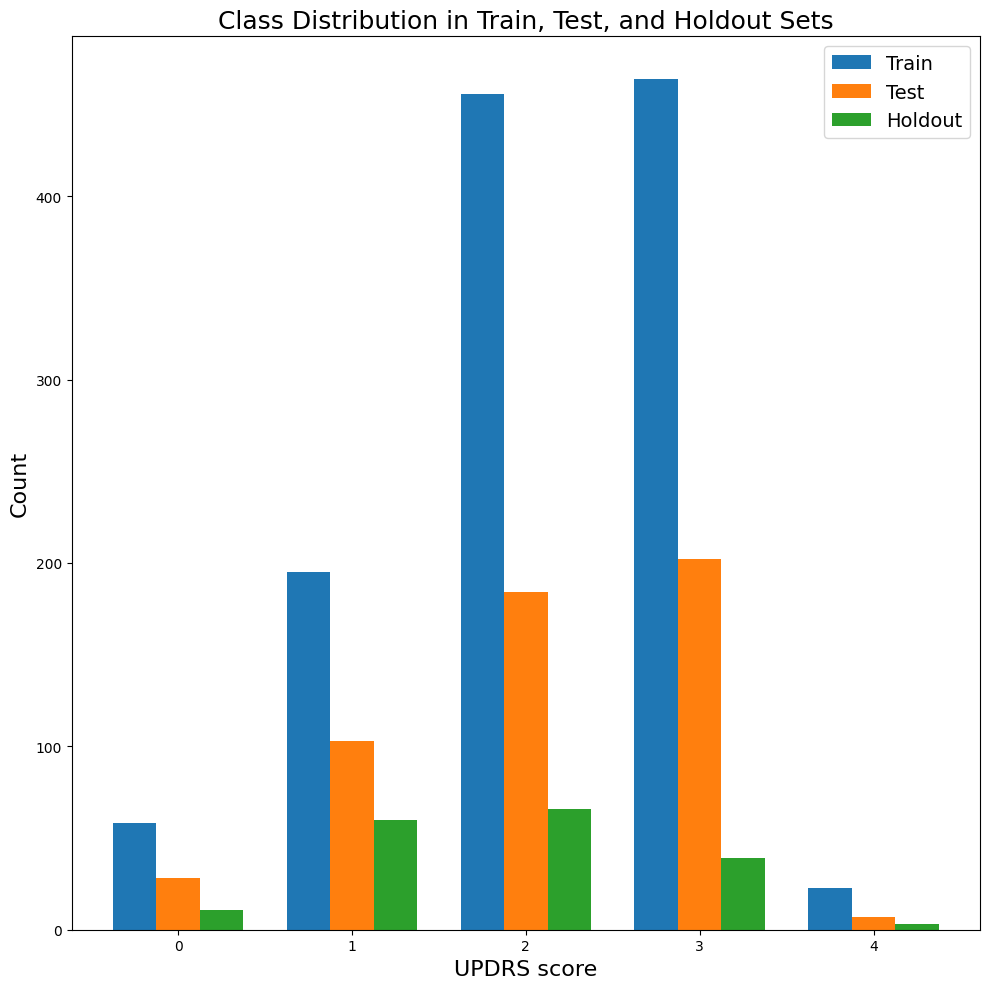

In [16]:
plt.figure(figsize=(10,10))
classes = np.unique(np.concatenate([y_train, y_test, y_holdout]))

train_counts = [np.sum(y_train == c) for c in classes]
test_counts = [np.sum(y_test == c) for c in classes]
holdout_counts = [np.sum(y_holdout == c) for c in classes]

x = np.arange(len(classes))
width = 0.25

plt.bar(x - width, train_counts, width=width, label="Train")
plt.bar(x, test_counts, width=width, label="Test")
plt.bar(x + width, holdout_counts, width=width, label="Holdout")

plt.xlabel("UPDRS score",fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(ticks=x, labels=classes)
plt.legend(fontsize=14)
plt.title("Class Distribution in Train, Test, and Holdout Sets", fontsize=18)
plt.tight_layout()
plt.show()